**Лабораторная работа 2**

Белов Владимир Станиславович ББМО-01-23

Задачи:
1. Реализовать атаки уклонения на основе белого ящика против
классификационных моделей на основе глубокого обучения.
2. Получить практические навыки переноса атак уклонения на основе
черного ящика против моделей машинного обучения.
1. Реализовать атаки уклонения на основе белого ящика против
классификационных моделей на основе глубокого обучения.

**Задание 1.** Обучить 2 классификатора на основе глубоких нейронных сетей
на датасете GTSRB. Использовать следующие модели нейронных сетей:
VGG16, ResNet50/10X, MobileNet v2/3. Выполнить поиск наилучших гиперпараметров моделей. Использовать бесплатные ресурсы GPU сервиса Google Colab. Составить отчёт:

(a) Заполнить Таблицу.

(b) Для каждой модели построить графики функции потерь для
данных валидации и тестирования и графики метрики Accuracy(ghbvth yf hbc/2).

**Задание 2.** Применить нецелевую атаку уклонения на основе белого ящика
против моделей глубокого обучения. Реализовать следующие типы атак: Fast Gradient Sign Method (FGSM) и Projected Gradient Descent (PGD).


Будем использовать код для реализации атак библиотеки Adversarial Robustness Toolbox ART.

In [ ]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.1 MB/s eta 0:00:00


Подключим необходимые библиотеки

In [ ]:
import cv2
import os
import torch
import random
import pickle
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

Загрузка датасета GTSRB из kaggle


In [12]:
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:06<00:00, 98.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [16]:
data_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

Прочитаем и выполним предварительную обработку изображений из набора данных

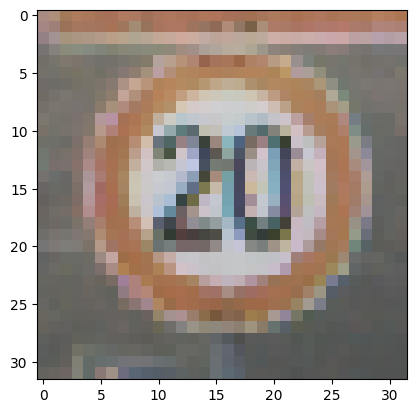

In [23]:
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
# Отобразим первый элемент в виде картинки
plt.imshow(data[0])

выполним разделение данных на треннировочный и тестовый набор 70/30 и выведем размер выборок

In [22]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)

training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)


Создаем модель глубокого обучения для классификации изображений методом ResNet50


In [25]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# История обучения для графика
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)
# Сохраняем модель
save_model(model, 'ResNet50.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 23,545,643 (89.82 MB)

 Non-trainable params: 577,664 (2.20 MB)

None
Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 2007s 5s/step - accuracy: 0.5756 - loss: 1.6646 - val_accuracy: 0.0998 - val_loss: 4.6820
Epoch 2/5
 68/429 ━━━━━━━━━━━━━━━━━━━━ 25:52 4s/step - accuracy: 0.9350 - loss: 0.2179

KeyboardInterrupt: 

Создаем модель глубокого обучения для классификации изображений методом VGG16

In [ ]:
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False
print(model2.summary())
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# История обучения для графика
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)
# Сохраняем модель
save_model(model2, 'VGG16.h5')

Создаем таблицу, с историей точности наших моделей

In [ ]:
from tabulate import tabulate
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = history_test.history['accuracy']

train_accuracy2 = history2_test.history['accuracy']
val_accuracy2 = history2_test.history['val_accuracy']
test_accuracy2 = history2_test.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)

Строим два графика процесса обучения модели ResNet50


In [ ]:


# График точности
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# График потерь
plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Строим два графика процесса обучения модели VGG16

In [ ]:
# График точности
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# График потерь
plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()